Get datafiles required:

In [245]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca10.0_asurf0.5.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.xlsx already retrieved. For overwrite use overwrite = True.
There are 138 files in data repository.
File tmp//fou_ring_0_4_0_8.dat already retrieved. For overwrite use overwrite = True.


Downloading...
From: https://docs.google.com/uc?export=download&id=1fq8djsdNl6JWq-bI2YDTKszcSuwcYnw1
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/fou_bmsca10.0_asurf0.5.dat
100%|██████████| 342k/342k [00:00<00:00, 852kB/s]

Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']

These are the parameter for our numerical experiment:

In [307]:
fou_file_ring = tmp_dir + "fou_ring_0_4_0_8.dat"
fou_file_planet = tmp_dir + "fou_bmsca10.0_asurf0.5.dat"

# Range of orbital inclinations to explore
iorbs = np.array([0,10,20,30,40,50,60,70,80,90]) # 

# Though ring is transparent we must provide options
tau_ring = 0.0 # Ring is transparent
ring_ri = 2.0
ring_re = 2.25
gamma = 80 # Ring inclination
alpha = 0 # Ring roll

# Scattering options
interp = "spline"
reference_plane = "Detector"

# Number of spangles
Ns = 30
Nb = 0
Np = 12000
Nr = 100

Let's run a single simulation:

In [308]:
# Make sure all output is printed
pr.Verbose.VERBOSITY=pr.VERB_NONE
iorb = iorbs[2]
value = iorb

# Calculate starting position of observer and star
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,alpha)
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg


Constant parameters:

In [310]:
a = 1
r_s = Consts.rsun
r_p = Consts.rsaturn
e = 0.0
theta_end = 360
n_theta = 361
allow_non_uni = False
normalize = True
lambq_offset = 0.0
limb_coeffs = [0.65]
interpr = "spline"
name = f"Orbit_incl80_fix"

Intialize system:

In [311]:
sys = pr.System()
s=sys.add(kind="Star",physics=dict(radius=r_s/sys.ul),optics=dict(limb_coeffs=limb_coeffs))
p=sys.add(kind="Planet", primary=s,
               radius=r_p/sys.ul,
               orbit=dict(a=a, e=e),
               physics=dict(radius=r_p/sys.ul),
               optics=dict(nspangles=Np))
r=sys.add(kind="Ring", primary=p,
               physics=dict(fi=ring_ri, fe=ring_re, i=ir),
               optics=dict(nspangles=Nr))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=fou_file_planet,
                       fname_ring=fou_file_ring)
RP.behavior["interp_method_ring"] = interpr
RP.behavior["allow_non_uni"] = allow_non_uni
RP.reference_plane = reference_plane

Now we will prepare the interval of longitudes and see the configuration:

In [312]:
lamb_initial = lamb_star
lamb_final = lamb_initial + theta_end*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,n_theta)

# Determine starting position in eccentric orbit, default is apocenter
if e >= 0.05:
    lq = np.linspace(0,2*np.pi,2000)
    d_max = 0
    lambq_max = 0
    for ii,l in enumerate(lq):
        RP.lambq = l
        RP.changeStellarPosition(lamb_initial)
        d = RP.rstar
        if d >= d_max:
            d_max = d
            lambq_max = l
    RP.lambq = lambq_max + lambq_offset*np.pi/180     

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

# Save images showing the starting position of planet, ring and star
ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=True,showfig=False)
for rf in "ecl","obs","star":
    fig=eval(f"{rf}_fig")
    save_figure(fig,f"fig_with_{name}_{value}_and_oi_{iorb}_rl_{alpha}_ri_{gamma}_rin_{ring_ri}_rout_{ring_re}_{rf}",
                fig_dir=fig_dir, dpi=300, formats=["png"])

Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_ecl.png...
Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_obs.png...
Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_star.png...


Let's preview the configuration:

<IPython.core.display.Javascript object>


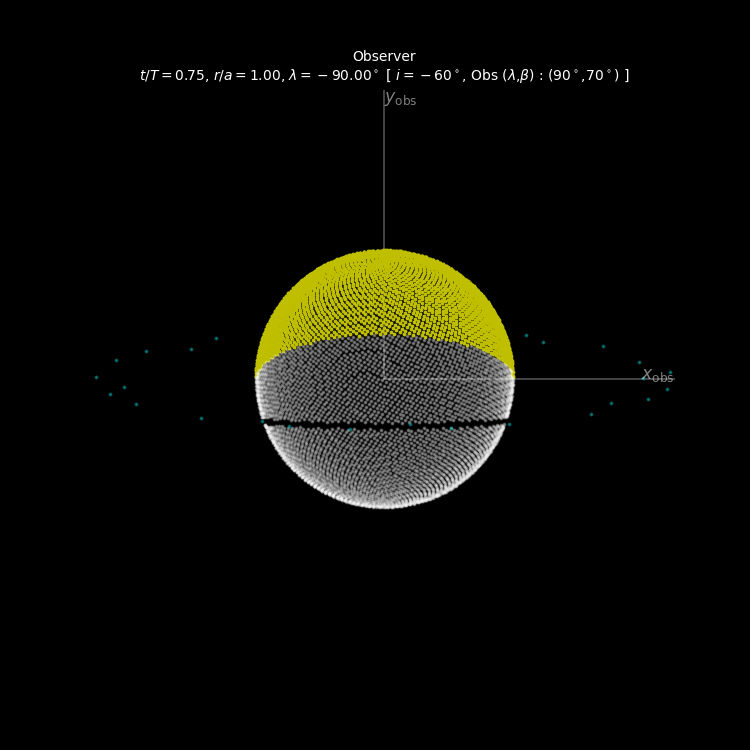

In [313]:
obs_fig

In [ ]:
plt.rcParams.update({'font.size': 25})

ring_i_arr = np.array([0,30,60,90]) # 90 is edge-on, 0 is face-on
ring_l_arr = np.array([0,30,60,90])
orbit_i_arr = np.array([20]) # 20 or 90

notext = True
fig = plt.figure(figsize=(36,36))
gs = fig.add_gridspec(ncols=4, nrows=4, hspace=0.12, width_ratios= [0.5,1,1,1])
axs = gs.subplots(sharex=True)

plot_line = [(0, (3, 1, 1, 1, 1, 1)),"--","-.",":"]
sub_plot_loc = [0.75,0.5,0.25,0.0]

for ii,orbit_i in enumerate(orbit_i_arr):
    for jj,ring_l in enumerate(ring_l_arr):
        for kk,ring_i in enumerate(ring_i_arr):
            save_location = f"/home/allard/Data/Geom_series_new/Orbit_i_{orbit_i}/Ring_L_{ring_l}/Ring_i_{ring_i}/"
            data_name = save_location + f"data_with_oi_{orbit_i}_rl_{ring_l}_ri_{ring_i}.pkl"
            figure_loc = save_location + f"fig_with_oi_{orbit_i}_rl_{ring_l}_ri_{ring_i}_obs.png"
            
            with open(data_name,"rb") as f:
                save_file = pickle.load(f)
                
            true_anomaly = np.array(save_file["lambda"])
            alpha = np.array(save_file["alpha"])
            Stot  = np.array(save_file["Stot"])
#             Sp    = np.array(save_file["Sp"])
#             Sr    = np.array(save_file["Sr"])
            Pflux = np.sqrt(Stot[:,1]**2 + Stot[:,2]**2)
            Ptot  = np.array(save_file["Ptot"])
            flux  = Stot[:,0]
            
            subpos = [0.0,sub_plot_loc[kk],0.5,0.25]
            subax1 = efunc.add_subplot_axes(axs[jj,0],subpos)
            figure = cv.imread(figure_loc)#, cv.IMREAD_UNCHANGED)
            
            b, g, r = cv.split(figure)
            tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
            _,alpha = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
            rgba = [r,g,b, alpha]
            figure = cv.merge(rgba,4)
#             rgba = [r,g,b]
#             figure = cv.merge(rgba,3)
            
            scale_percent = 80
            width = int(figure.shape[1] * scale_percent / 100)
            height = int(figure.shape[0] * scale_percent / 100)
            dim = (width,height)
            resized = cv.resize(figure, dim, interpolation = cv.INTER_AREA)
            subax1.imshow(resized, interpolation='bicubic', aspect='auto')
            if kk==0:
                subax1.text(0.0, 1.15, f'$\lambda_r = {ring_l}^\circ$',
                            {'fontsize': 35}, horizontalalignment='left',
                            verticalalignment='center', transform=subax1.transAxes)
            subax1.text(1.3, 0.5, f'$\gamma = {ring_i}^\circ$', {'fontsize': 30},
                        horizontalalignment='left', verticalalignment='center', 
                        transform=subax1.transAxes)
            subax1.set_axis_off()
            axs[jj,0].set_axis_off()
            
            axs[jj,1].plot(true_anomaly,flux,linestyle=plot_line[kk],label=f"{ring_i}$^\circ$",linewidth=3)
            axs[jj,2].plot(true_anomaly,Pflux,linestyle=plot_line[kk],label=f"Inclination {ring_i}",linewidth=3)
            axs[jj,3].plot(true_anomaly,abs(Ptot),linestyle=plot_line[kk],label=f"Inclination {ring_i}",linewidth=3)
            axs[jj,1].legend()
            
            print(f"Orbit inclination: {orbit_i}, Ring inclination: {ring_i}, Ring longitude: {ring_l} \n" +\
                  f"Max value flux = {np.max(flux)}")
            
            ### Result of just planet ###
            if kk == 0:
                data_loc = f"/home/allard/Data/Orbit_incl80_fix_Series/Orbit_incl80_fix_{orbit_i}/"
                data_name = data_loc + f"data_with_Orbit_incl80_fix_{orbit_i}.pkl"

                with open(data_name,"rb") as f:
                    save_file = pickle.load(f)
                true_anomaly = np.array(save_file["lambda"])
                alpha = np.array(save_file["alpha"])
                Sp = np.array(save_file["Sp"])
                Pflux = np.sqrt(Sp[:,1]**2 + Sp[:,2]**2)
                Pp = np.array(save_file["Pp"])
                flux = Sp[:,0]
                axs[jj,1].plot(true_anomaly,flux,linestyle="-",color="k",linewidth=3)
                axs[jj,2].plot(true_anomaly,Pflux,linestyle="-",color="k",linewidth=3)
                axs[jj,3].plot(true_anomaly,abs(Pp),linestyle="-",color="k",linewidth=3)

            # For 90 deg
#             efunc.setup(axs[jj,1],60,0,360,0.2,-0.025,1.02,notext=notext)
#             efunc.setup(axs[jj,2],60,0,360,0.02,-0.0025,0.1,notext=notext)
#             efunc.setup(axs[jj,3],60,0,360,0.05,-0.01,0.4,notext=notext)

            # For 20 deg
            efunc.setup(axs[jj,1],60,0,360,0.05,-0.01,0.42,notext=notext)
            efunc.setup(axs[jj,2],60,0,360,0.02,-0.0025,0.1,notext=notext)
            efunc.setup(axs[jj,3],60,0,360,0.05,-0.01,0.4,notext=notext)
            
            axs[jj,1].set_ylabel("Flux",fontsize=35)
            axs[jj,2].set_ylabel("Polarized flux",fontsize=35)
            axs[jj,3].set_ylabel("Degree of polarization",fontsize=35)
            if jj ==3:
                axs[3,1].set_xlabel("True anomaly [deg]",fontsize=35)
                axs[3,2].set_xlabel("True anomaly [deg]",fontsize=35)
                axs[3,3].set_xlabel("True anomaly [deg]",fontsize=35)

for jj in range(len(ring_l_arr)):
    axs[jj,1].grid()
    axs[jj,2].grid()
    axs[jj,3].grid()

fig.savefig("/home/allard/Results/Geom_orbit_i_20_low.svg", bbox_inches='tight', format='svg', dpi=600)
#.eps", format='eps', bbox_inches='tight')
plt.show()
plt.rcParams.update({'font.size': 20})And plot the results: